# Mushroom Classification

## Introduction
I was looking for interesting data to makes a project with, and I stumble on this data set on Kaggle. Like usual I look around others notebooks on kaggle to feel out the presentation. I found out that most notebook use label encoding instead of onehot encoding. I agree that onehot encoding produce a large amount of features, and label encoding is easier to do. However, with some features engineering, we can easily removes most of the features. And that is how I ended up doing this project with onehot encoding.

In [68]:
# Import necessary libraries for analysis and visualization
#data manipulation lib
import pandas as pd
import numpy as np

#plot lib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

#data lib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.preprocessing import OneHotEncoder

#model lib
import xgboost as xgb

import warnings


In [69]:
#load the data set
file_path = 'mushrooms.csv'
df = pd.read_csv(file_path)

# encode class with 0 be poisonous
count = 0
for i in df['class']:
    if i == 'e':
        df.loc[count, "class"] = 1
    else:
        df.loc[count, "class"] = 0
    count += 1

df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,1,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,0,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,1,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


### doing some EDA to familarize the data set

<Axes: >

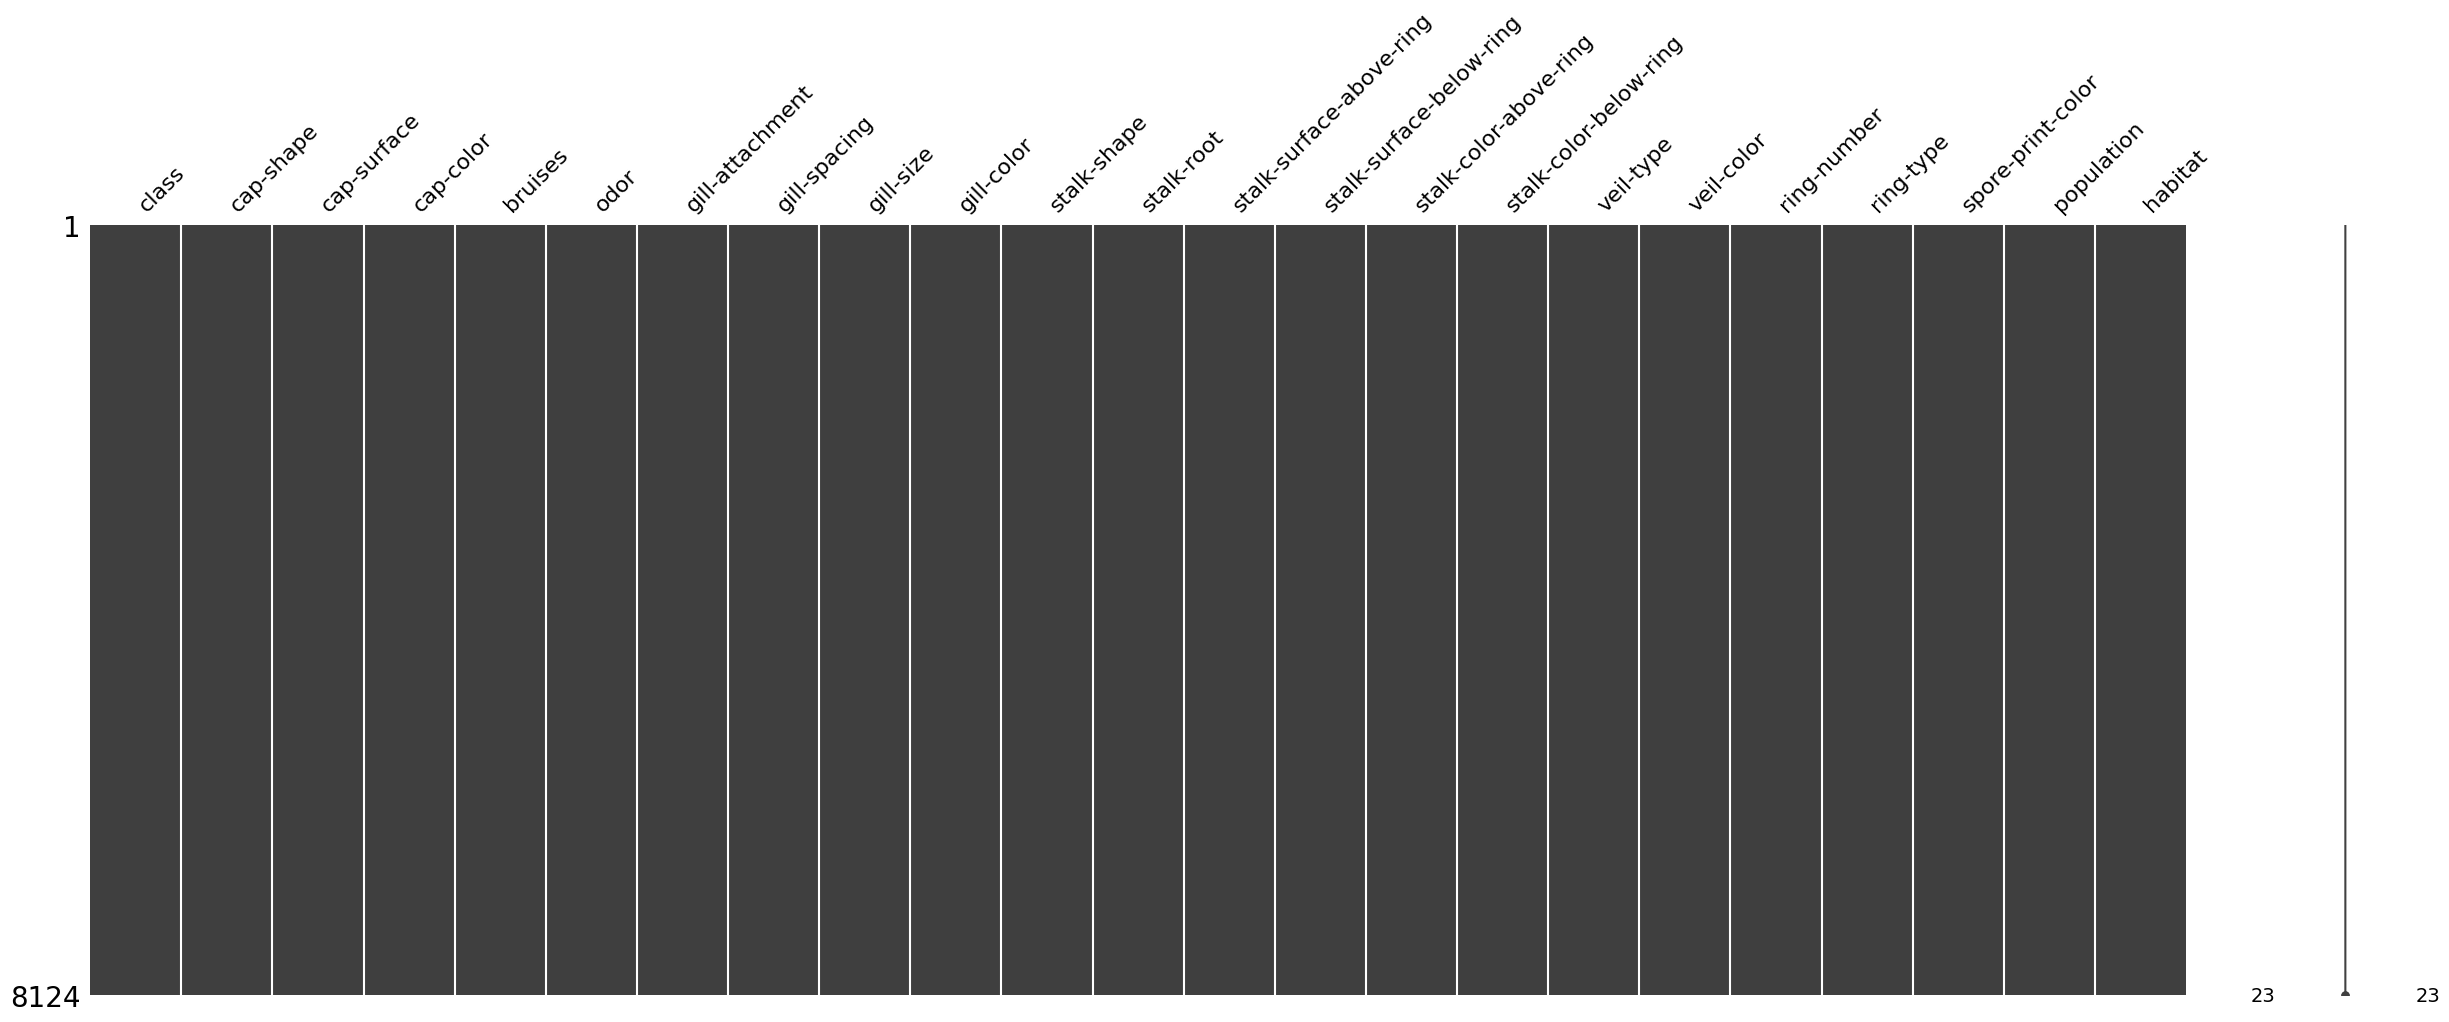

In [70]:
#missing data matrix
missingno.matrix(df, figsize=(30,10))

### Notes
- No missing variable in any columns
- Next I want to show correlations matrix to choose some good features
- Since all of our features is purely nominal I want to use onehot encoding

In [71]:
# onehot encode features 
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns.pop(0) #pop 'class' out of the encode objects since we already encoded it

encoder = OneHotEncoder(sparse_output=False)

one_hot_encoded = encoder.fit_transform(df[categorical_columns])

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

df_encoded = pd.concat([df, one_hot_df], axis=1)

df_encoded = df_encoded.drop(categorical_columns, axis=1)
df_encoded.head()


,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_?,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

<Axes: >

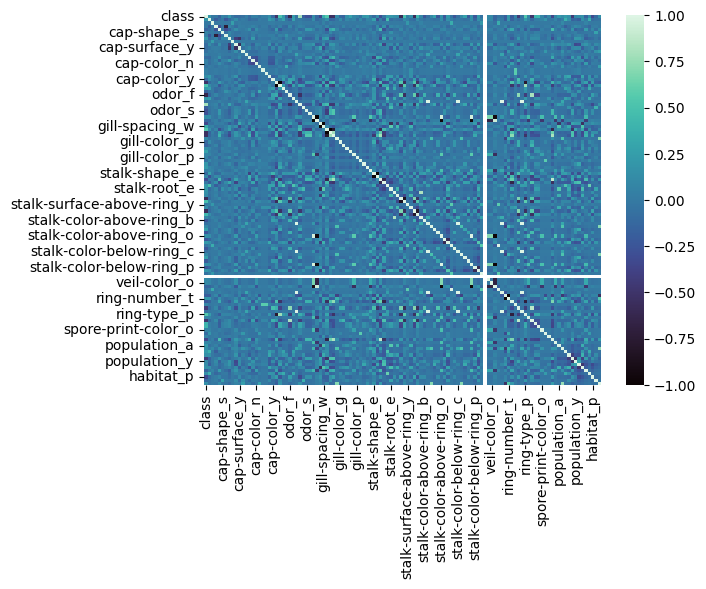

In [72]:
sns.heatmap(df_encoded.corr(), cmap='mako')

### Notes
- Not really helpful since we have 118 features after encoding
- So, I would print the whole correlation down below

In [73]:
pd.set_option('display.max_columns', 4000)
df_encoded.corr()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_?,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
class,1.000000,0.182567,-0.023007,-0.018526,-0.163565,0.060664,0.026886,0.195415,-0.023007,-0.095454,-0.088677,-0.067544,0.030910,-0.097112,0.046456,0.044360,-0.034702,0.042854,0.042854,0.133683,-0.113014,-0.501530,0.501530,0.219529,-0.161278,-0.623842,0.219529,-0.069159,0.785557,-0.186984,-0.286360,-0.286360,0.129200,-0.129200,-0.348387,0.348387,0.540024,-0.540024,-0.538808,0.105491,-0.120285,-0.150694,0.149641,0.288943,0.085962,0.050380,-0.056426,0.195359,0.231316,0.046828,-0.102019,0.102019,-0.302001,-0.017712,0.218548,0.202839,0.150087,0.119503,-0.587658,0.491314,0.016198,0.136782,-0.573524,0.425444,0.081674,-0.245662,-0.069159,0.105491,0.266489,-0.233164,0.150087,-0.230277,0.217740,-0.032545,-0.245662,-0.069159,0.105491,0.266489,-0.203966,0.150087,-0.230277,0.214112,-0.056426,NaN,0.105491,0.105491,-0.140541,-0.032545,-0.069159,-0.182101,0.204600,-0.223286,0.074371,-0.451619,-0.069159,0.540469,0.074371,-0.490229,0.396832,0.416645,0.074371,-0.098024,0.074371,-0.357384,0.074371,0.214871,0.137645,0.219529,0.159572,-0.443722,0.107055,0.126123,0.165004,-0.155150,0.138627,-0.323346,-0.112078,0.150087
cap-shape_b,0.182567,1.000000,-0.005387,-0.193260,-0.081769,-0.015264,-0.219564,-0.091638,0.018820,0.117712,-0.027947,0.010011,-0.017912,-0.115505,-0.069760,-0.084902,0.016231,-0.010782,-0.010782,0.212380,0.117981,-0.115686,0.115686,0.262455,-0.037764,-0.146074,0.262455,-0.016194,-0.000314,-0.043783,-0.067052,-0.067052,0.122896,-0.122896,-0.039406,0.039406,0.148449,-0.148449,-0.126163,-0.026543,0.122587,-0.076382,0.101547,0.034751,0.075558,-0.070747,0.105523,-0.061628,0.084884,0.064095,0.277873,-0.277873,0.016347,-0.180976,0.482914,-0.097062,-0.037764,-0.065536,-0.089730,0.113938,0.046155,-0.068543,-0.095534,0.126883,-0.005266,-0.057522,-0.016194,-0.026543,-0.067052,-0.049229,0.131922,-0.132818,0.161500,0.026622,-0.057522,-0.016194,-0.026543,-0.067052,-0.045272,0.131922,-0.132818,0.157391,0.046155,NaN,0.092724,0.092724,-0.134710,0.026622,-0.016194,-0.201139,0.210701,-0.163553,-0.018713,-0.105748,-0.016194,0.237666,0.065370,-0.121699,0.030409,0.038235,0.065370,0.183315,-0.018713,-0.024592,0.065370,-0.054064,0.024358,0.381589,0.15870

### Notes
- really long but I would summarize what I find below
- First, there is some subfeatures with really high correlation
- Second, features of high correlation subfeatures often haves multiple high correlation subfeatures
- Therefore, it is worth to study those features with high correlation subfeatures
- I would study bruise, odor, gill-size, gill-color, stalk surface above ring, stalk surface below ring, ring type

### Bruises

<Axes: xlabel='bruises', ylabel='Count'>

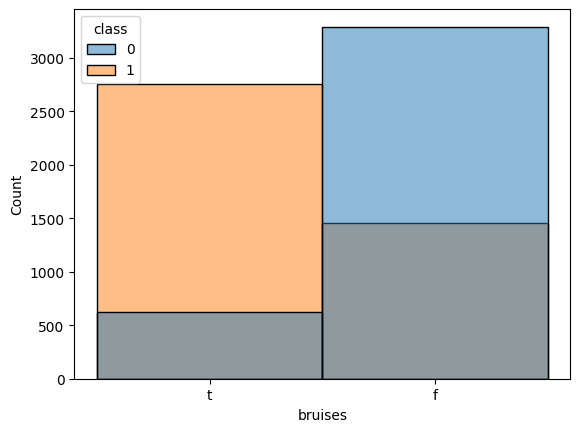

In [74]:
sns.histplot(data=df, x="bruises", hue="class")

### Notes
- Bruises have 2 value, so we can actually represent them in the form of 0 and 1 for mushroom don't have bruised and mushroom does have bruises
- the percentage of mushroom being edible given it have bruises is pretty high

<Axes: xlabel='odor', ylabel='Count'>

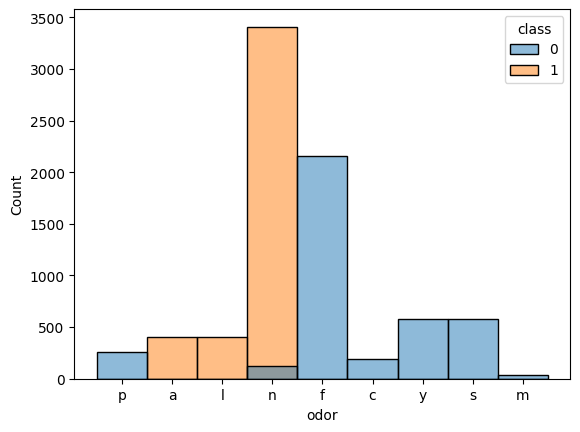

In [75]:
sns.histplot(data=df, x="odor", hue="class")

### Notes
- The seperation between edible and poisonous odor are pretty clear, so we can creates a new features where all poisonous high smell is 0 and all edible smell is 1
- non smell have some poisonous in it, but we could deter it by others features

<Axes: xlabel='gill-size', ylabel='Count'>

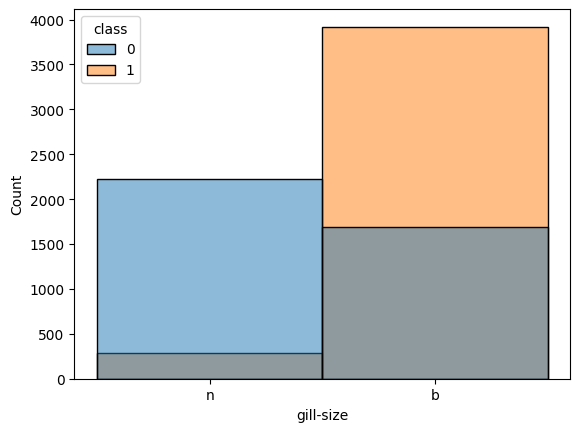

In [76]:
sns.histplot(data=df, x="gill-size", hue="class")

### Notes 
- gill-size have 2 value, so we can actually represent them in the form of 0 and 1 
- the percentage of mushroom being poisonous given it have narrow gill is pretty high

<Axes: xlabel='gill-color', ylabel='Count'>

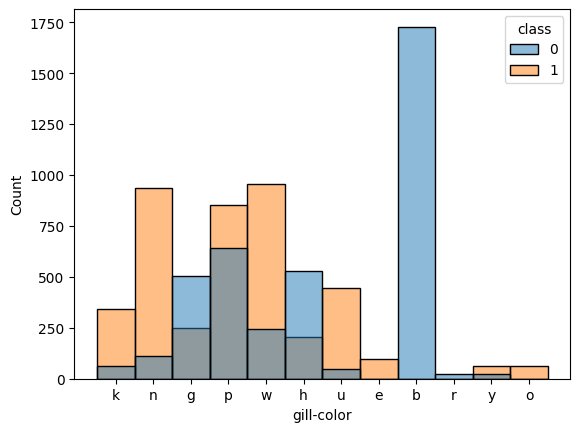

In [77]:
sns.histplot(data=df, x="gill-color", hue="class")

### Notes
- For gill colors I would also select subfeatures which haves higher chance to be edible to be 1 and high chance to be poisonous percentage to be 0
- which include k,n,u,e,o for 1 and g,h,b,r to be 0
- I know g and h doesn't have that much higher percentage to be poisonous, but it better to be safe and misidentify an edible mushroom, than a poisonous one. So, I choose g and h. 

<Axes: xlabel='stalk-surface-above-ring', ylabel='Count'>

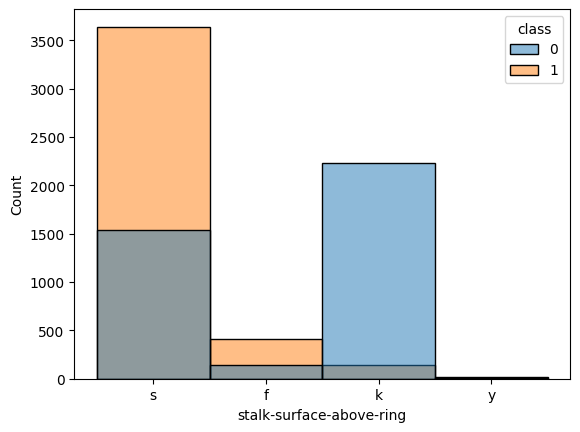

In [78]:
sns.histplot(data=df, x="stalk-surface-above-ring", hue="class")

### Notes
- I will keep only the k subfeatures in this features

<Axes: xlabel='stalk-surface-below-ring', ylabel='Count'>

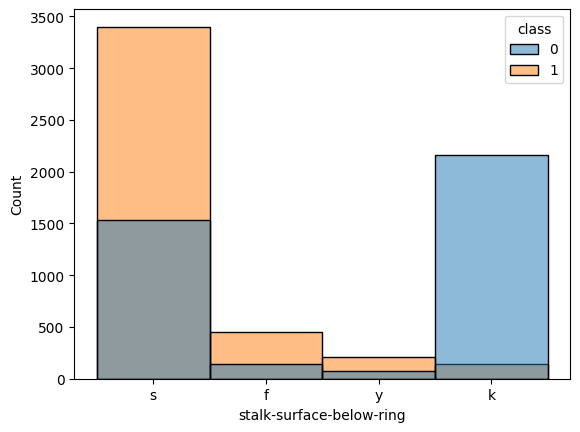

In [79]:
sns.histplot(data=df, x="stalk-surface-below-ring", hue="class")

### Notes
- I will keep only the k subfeatures in this features

<Axes: xlabel='ring-type', ylabel='Count'>

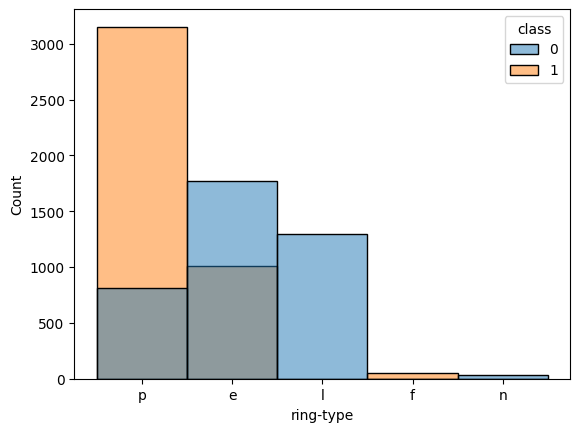

In [80]:
sns.histplot(data=df, x="ring-type", hue="class")

### Notes 
- For ring type I would also select subfeatures which haves higher chance to be edible to be 1 and high chance to be poisonous percentage to be 0
- which I choose p,f to be 1 and l, n to be 0

Now I just need to removes all the features and creates new features base on these information

In [81]:
# creates new odor feature
count = 0
for i in df['odor']:
    if i == 'a' or i == 'l' or i == 'n':
        df.loc[count, "odor"] = 1
    else:
        df.loc[count, "odor"] = 0
    count += 1
odor = df['odor']

In [82]:
# check odor
print(odor)

0       0
1       1
2       1
3       0
4       1
       ..
8119    1
8120    1
8121    1
8122    0
8123    1
Name: odor, Length: 8124, dtype: object


In [83]:
# encode bruises feature
count = 0
for i in df['bruises']:
    if i == 't':
        df.loc[count, "bruises"] = 1
    else:
        df.loc[count, "bruises"] = 0
    count += 1
bruises = df['bruises']

In [84]:
# check bruises
print(bruises)

0       1
1       1
2       1
3       1
4       0
       ..
8119    0
8120    0
8121    0
8122    0
8123    0
Name: bruises, Length: 8124, dtype: object


In [85]:
# encode gill size 
count = 0
for i in df['gill-size']:
    if i == 'b':
        df.loc[count, "gill-size"] = 1
    else:
        df.loc[count, "gill-size"] = 0
    count += 1
gillSize = df['gill-size']

In [86]:
# check gill size
print(gillSize)

0       0
1       1
2       1
3       0
4       1
       ..
8119    1
8120    1
8121    1
8122    0
8123    1
Name: gill-size, Length: 8124, dtype: object


In [87]:
# Create new feature for gill color
count = 0
for i in df['gill-color']:
    if i == 'k' or i == 'n' or i == 'u' or i == 'o' or i == 'e':
        df.loc[count, "gill-color"] = 1
    elif i == 'g' or i == 'h' or i == 'b' or i == 'r':
        df.loc[count, "gill-color"] = 0
    else:
        df.loc[count, 'gill-color'] = float('nan')
    count += 1
gillColor = df['gill-color']

In [88]:
# check gill color
print(gillColor)

0         1
1         1
2         1
3         1
4         1
       ... 
8119    NaN
8120    NaN
8121      1
8122      0
8123    NaN
Name: gill-color, Length: 8124, dtype: object


In [89]:
# keep stalk surface subfeature k for below and above ring in onehot encode
stalkAbove = df_encoded['stalk-surface-above-ring_k']
stalkBelow = df_encoded['stalk-surface-below-ring_k']

In [90]:
# Create new feature for ring type
count = 0
for i in df['ring-type']:
    if i == 'p' or i == 'f':
        df.loc[count, "ring-type"] = 1
    elif i == 'l' or i == 'n':
        df.loc[count, "ring-type"] = 0
    else:
        df.loc[count, 'ring-type'] = float('nan')
    count += 1
ringType = df['ring-type']

In [91]:
# drop everything except class that already encoded
df = df.drop(columns=categorical_columns)


In [92]:
# add new features in also change it type from object to int
df['class'] = df['class'].convert_dtypes(convert_integer=True)
df['bruises'] = bruises.convert_dtypes(convert_integer=True)
df['odor'] = odor.convert_dtypes(convert_integer=True)
df['gill-size'] = gillSize.convert_dtypes(convert_integer=True)
df['gill-color'] = gillColor.convert_dtypes(convert_integer=True)
df['stalk-surface-above-ring'] = stalkAbove
df['stalk-surface-below-ring'] = stalkBelow
df['ring-type'] = ringType.convert_dtypes(convert_integer=True)
df.head()

,class,bruises,odor,gill-size,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,ring-type
0,0,1,0,0,1,0.0,0.0,1
1,1,1,1,1,1,0.0,0.0,1
2,1,1,1,1,1,0.0,0.0,1
3,0,1,0,0,1,0.0,0.0,1
4,1,0,1,1,1,0.0,0.0,<NA>


### Notes
- Now we check again for correlation

<Axes: >

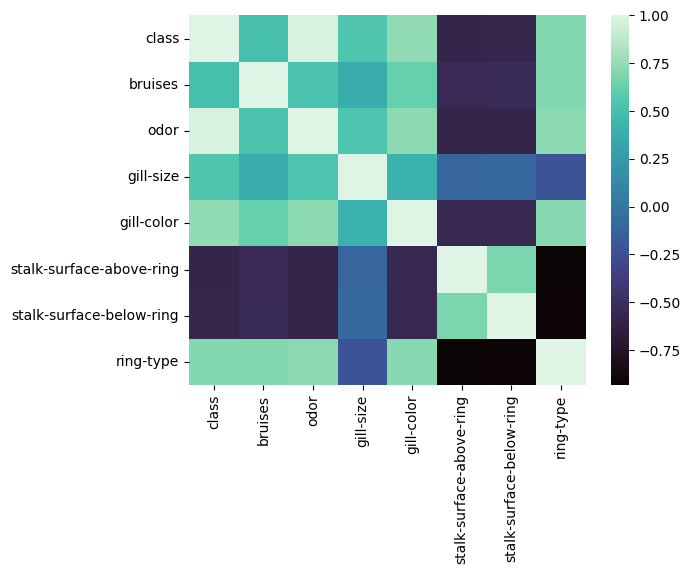

In [93]:
sns.heatmap(df.corr(), cmap = 'mako')

In [94]:
df.corr()

,class,bruises,odor,gill-size,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,ring-type
class,1.000000,0.501530,0.970814,0.540024,0.742968,-0.587658,-0.573524,0.702932
bruises,0.501530,1.000000,0.517370,0.369596,0.627456,-0.541494,-0.530549,0.698575
odor,0.970814,0.517370,1.000000,0.535020,0.726805,-0.590190,-0.593014,0.725299
gill-size,0.540024,0.369596,0.535020,1.000000,0.409381,-0.095225,-0.089569,-0.222761
gill-color,0.742968,0.627456,0.726805,0.409381,1.000000,-0.569430,-0.569430,0.716844
stalk-surface-above-ring,-0.587658,-0.541494,-0.590190,-0.095225,-0.569430,1.000000,0.677074,-0.932781
stalk-surface-below-ring,-0.573524,-0.530549,-0.593014,-0.089569,-0.569430,0.677074,1.000000,-0.913659
ring-type,0.702932,0.698575,0.725299,-0.222761,0.716844,-0.932781,-0.913659,1.000000


In [95]:
# I acidantally makes my type object, so now I have to turn it into float

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     8124 non-null   Int64  
 1   bruises                   8124 non-null   Int64  
 2   odor                      8124 non-null   Int64  
 3   gill-size                 8124 non-null   Int64  
 4   gill-color                5344 non-null   Int64  
 5   stalk-surface-above-ring  8124 non-null   float64
 6   stalk-surface-below-ring  8124 non-null   float64
 7   ring-type                 5348 non-null   Int64  
dtypes: Int64(6), float64(2)
memory usage: 555.5 KB


### Notes
- pretty good, so we go straight into model training

In [96]:
featureColums = df.columns.tolist()
featureColums.pop()
features = df[featureColums]
target = df[['class']]

Accuracy = 1.0
ROC Area under Curve = 1.0
              precision    recall  f1-score   support

         0.0    1.00000   1.00000   1.00000      1011
         1.0    1.00000   1.00000   1.00000      1020

    accuracy                        1.00000      2031
   macro avg    1.00000   1.00000   1.00000      2031
weighted avg    1.00000   1.00000   1.00000      2031



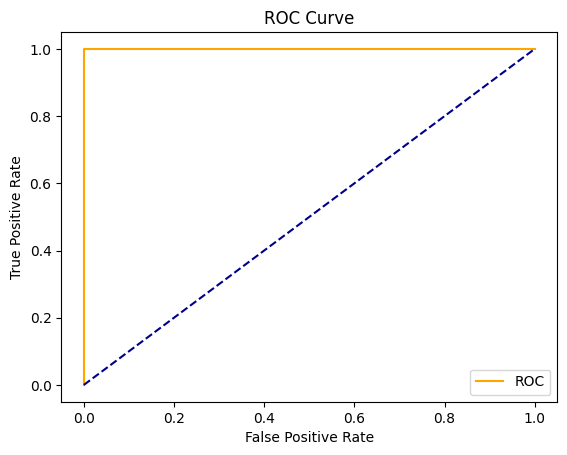

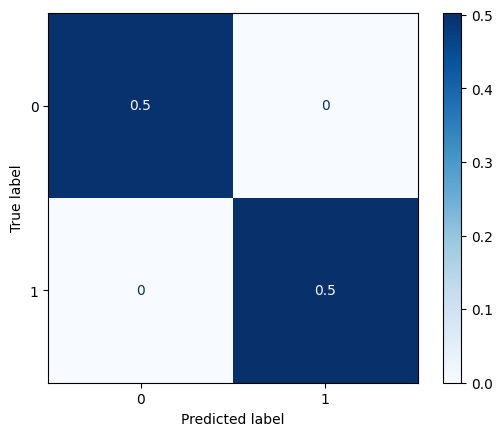

In [97]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)

def plotRoc(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def runModel(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plotRoc(fper, tper)

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    plt.show()
    return model, accuracy, roc_auc

params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb = runModel(model_xgb,X_train,y_train,X_test,y_test)